## 1.数据清理
### 1.1 4C法则:Correcting,Completing,Creating,Converting
##### $~~ $  **1.Correcting**: 剔除异常或不合理数据，例如年龄1000岁。
##### $~~ $  **2.Completing**: 补齐缺失值。
##### $~~ $  **3.Creating**: 利用已有特征创造新的有效特征。
##### $~~ $  **4.Converting**: 将日期、地名或者类别型特征转化为数值型特征。

In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [6]:
#import data from file: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
data_raw1 = pd.read_csv('train.csv')


#a dataset should be broken into 3 splits: train, test, and (final) validation
#the test file provided is the validation file for competition submission
#we will split the train set into train and test data in future sections
data_raw2  = pd.read_csv('test.csv')


#to play with our data we'll create a copy
#remember python assignment or equal passes by reference vs values, so we use the copy function: https://stackoverflow.com/questions/46327494/python-pandas-dataframe-copydeep-false-vs-copydeep-true-vs
data1 = data_raw1.copy(deep = True)
data2 = data_raw2.copy(deep = True)

#however passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1, data2]


#preview data
print (data1.info()) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html
#data_raw.head() #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html
#data_raw.tail() #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.tail.html
data1.sample(10) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
49,50,0,3,"Arnold-Franchi, Mrs. Josef (Josefine Franchi)",female,18.0,1,0,349237,17.8000,NaN,S
534,535,0,3,"Cacic, Miss. Marija",female,30.0,0,0,315084,8.6625,NaN,S
185,186,0,1,"Rood, Mr. Hugh Roscoe",male,NaN,0,0,113767,50.0000,A32,S
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
174,175,0,1,"Smith, Mr. James Clinch",male,56.0,0,0,17764,30.6958,A7,C
160,161,0,3,"Cribb, Mr. John Hatfield",male,44.0,0,1,371362,16.1000,NaN,S
578,579,0,3,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1,0,2689,14.4583,NaN,C
304,305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.0500,NaN,S
647,648,1,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C
316,317,1,2,"Kantor, Mrs. Sinai (Miriam Sternin)",female,24.0,1,0,244367,26.0000,NaN,S


In [7]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data2.isnull().sum())
print("-"*10)

data1.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Mangan, Miss. Mary",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


### 1.2 数据清理常用方法文档

* [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
* [pandas.DataFrame.info](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html)
* [pandas.DataFrame.describe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.describe.html)
* [Indexing and Selecting Data](https://pandas.pydata.org/pandas-docs/stable/indexing.html)
* [pandas.isnull](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.isnull.html)
* [pandas.DataFrame.sum](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sum.html)
* [pandas.DataFrame.mode](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.mode.html)
* [pandas.DataFrame.copy](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.copy.html)
* [pandas.DataFrame.fillna](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html)
* [pandas.DataFrame.drop](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html)
* [pandas.Series.value_counts](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html)
* [pandas.DataFrame.loc](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html)

In [8]:
###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
for dataset in data_cleaner:
    dataset.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data2.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


<a id="ch6"></a>
## 2.数据分析与特征工程
数据清理结束后将分析数据的统计特性以获得关于数据的直观认识，从而有利于构造有效特征

In [9]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


    
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
for dataset in data_cleaner:
    title_names = (dataset['Title'].value_counts() < stat_min) #this will create a true false series with title name as index
    #apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
    dataset['Title'] = dataset['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    print("-"*10)
    print(dataset['Title'].value_counts())
#preview data again
data1.info()
data2.info()
data1.sample(10)

----------
Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
Pclass        418 non-nu

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
641,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,69.3000,C,1,1,Misc,"(31.0, 512.329]","(16.0, 32.0]"
626,0,2,"Kirkland, Rev. Charles Leonard",male,57.0,0,0,12.3500,Q,1,1,Misc,"(7.91, 14.454]","(48.0, 64.0]"
188,0,3,"Bourke, Mr. John",male,40.0,1,1,15.5000,Q,3,0,Mr,"(14.454, 31.0]","(32.0, 48.0]"
130,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,7.8958,C,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
864,0,2,"Gill, Mr. John William",male,24.0,0,0,13.0000,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
220,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(-0.08, 16.0]"
812,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,10.5000,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"
115,0,3,"Pekoniemi, Mr. Edvard",male,21.0,0,0,7.9250,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
519,0,3,"Pavlovic, Mr. Stefo",male,32.0,0,0,7.8958,S,1,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
383,1,1,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",female,35.0,1,0,52.0000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"


### 2.1 数据类型转换

类别型特征转换为数值型特征的实现方法：

** 开发文档: **
* [Categorical Encoding](http://pbpython.com/categorical-encoding.html)
* [Sklearn LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)
* [Sklearn OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
* [Pandas Categorical dtype](https://pandas.pydata.org/pandas-docs/stable/categorical.html)
* [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)

In [10]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')
print(data_val.columns.tolist())

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



NameError: name 'data_val' is not defined

In [11]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

以上结果表明生还概率与四个关键特征具有强关联，分别是性别、舱级、堂兄弟/妹个数、父母及孩子个数

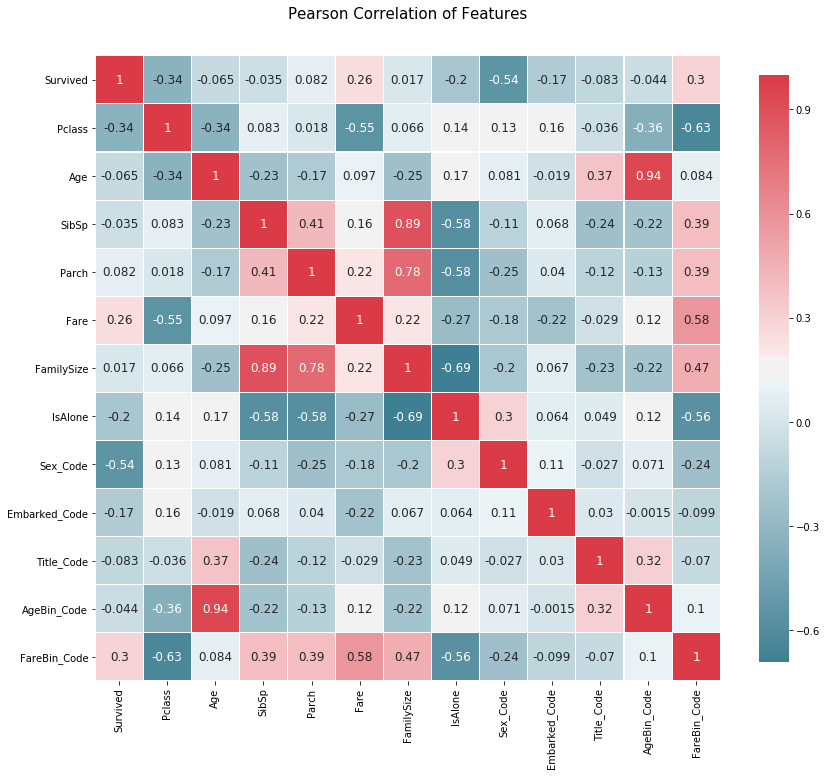

In [12]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)

热力图描述了变量之间的相关程度，例如生还与性别、舱级强相关；此外，通过分析变量之间的相关性，剔除强相关变量，从而能够降低特征矩阵维度，减少内存使用，加快训练速度。

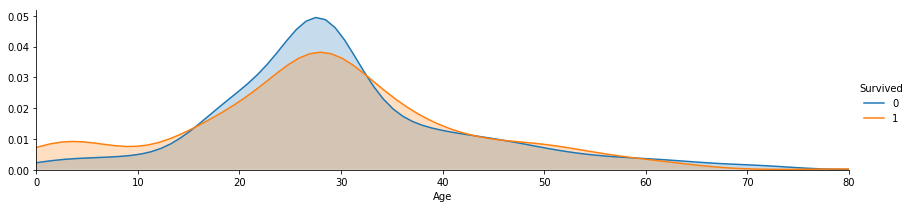

In [13]:
#plot distributions of age of passengers who survived or did not survive
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
a.map(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

Text(0.5,1,'Sex vs IsAlone Survival Comparison')

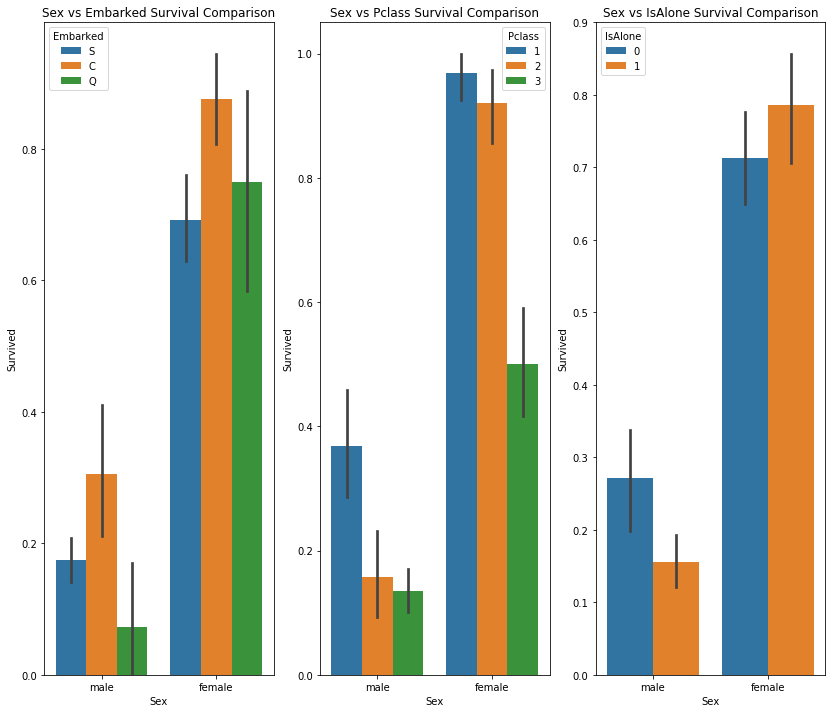

In [14]:
#graph distribution of qualitative data: Sex
#we know sex mattered in survival, now let's compare sex and a 2nd feature
#graph distribution of qualitative data: Pclass
#we know class mattered in survival, now let's compare class and a 2nd feature
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
qaxis[0].set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
qaxis[1].set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
qaxis[2].set_title('Sex vs IsAlone Survival Comparison')

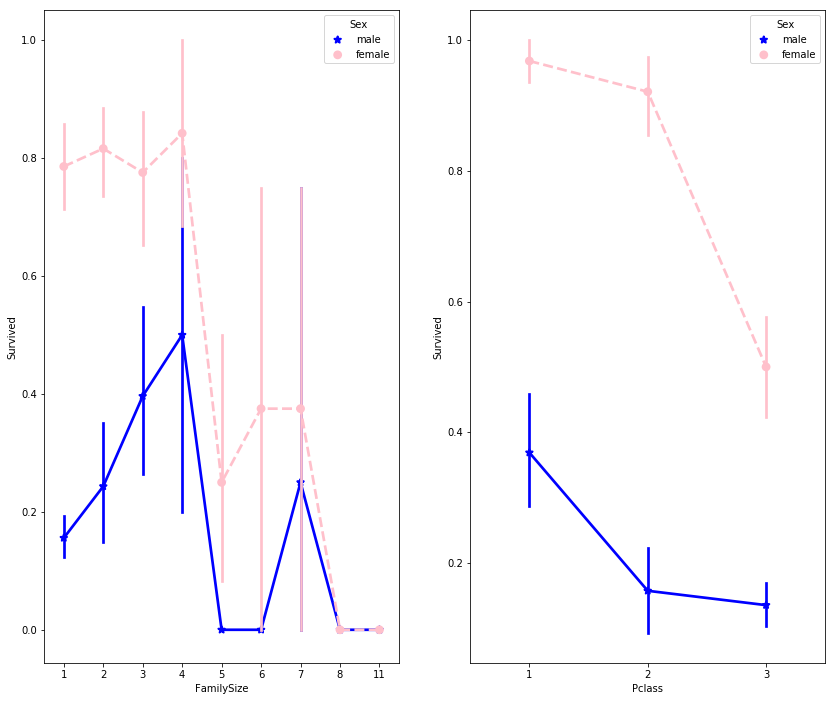

In [15]:
#more side-by-side comparisons
fig, (maxis1, maxis2) = plt.subplots(1, 2,figsize=(14,12))

#how does family size factor with sex & survival compare
sns.pointplot(x="FamilySize", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis1)

#how does class factor with sex & survival compare
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data1,
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"], ax = maxis2)

特征构造的好坏与否对于最后预测精度具有决定性作用，所谓garbage in, garbage out讲的就是这个道理

## 3.模型训练

In [16]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 10)
Test1 Shape: (223, 10)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [21]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Submit Accuracy', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
submit_result = pd.read_csv('gender_submission.csv')
submit_survived = submit_result['Survived']

#index through MLA and save performance to table
row_index = 0
alg_max = None
alg_score = float(0)
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    #MLA_predict
    MLA_compare.loc[row_index, 'MLA Submit Accuracy'] = alg.score(data2[data1_x_bin], submit_survived)
    #Search for alg_max
    if alg_score < cv_results['test_score'].mean():
        alg_score = cv_results['test_score'].mean()
        alg_max = alg
    row_index+=1

#save submit.csv
predictions = alg_max.predict(data2[data1_x_bin])
result = pd.DataFrame({'PassengerId':submit_result['PassengerId'].as_matrix(),'Survived':predictions.astype(np.int32)})
result.to_csv('submit.csv',index=False)
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Submit Accuracy,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.856367,0.829478,0.894737,0.0527546,0.0157419
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.947368,0.0453876,0.0245653
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.942584,0.0493681,0.0284756
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.89176,0.822015,0.868421,0.0704513,0.01053
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.822015,0.839713,0.0600839,0.0114305
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822015,0.88756,0.0529916,0.0485293
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.822015,0.837321,0.0505717,0.00140376
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.890637,0.816418,0.851675,0.0550218,0.0113299
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.814552,0.861244,0.0596653,0.00130355
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.842105,0.0690863,0.00120337


Text(0,0.5,'Algorithm')

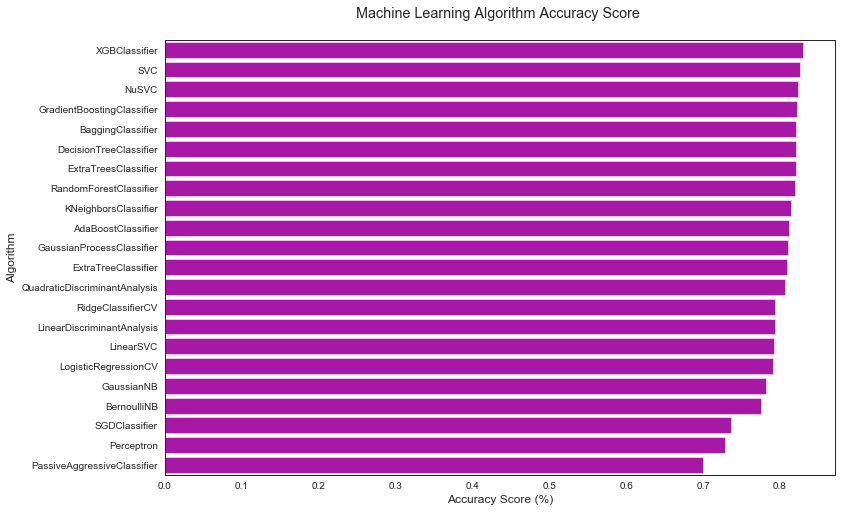

In [37]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## 4.总结
1. 学习完成一个比赛的基本流程；
2. 学习pandas的使用
3. 学习处理数据的基本方法：补缺，scaling
4. 学习逻辑回归模型的构建方法
5. 有待提高：
 - 对数据集，特征需要更深度的分析
 - 可以尝试其他模型，或者对本模型进行更为深度的分析
 - 尝试其他机器学习算法
6. 有些线下成绩与线上准确率出现不一致的处理
![title](submit.png)